<img src="../../images/BikeDNA_logo.svg" width="250"  alt="BikeDNA logo" style="display:block; margin-left: auto; margin-right: auto;">
<a href="https://github.com/anerv/BikeDNA">Github</a>

# 1a. Initialize OSM data

This notebook:

- Loads the polygon defining the study area and then creates a grid overlay for the study area.
- Downloads street network data for the study area using OSMnx.
- Creates a network only with bicycle infrastructure (with queries defined in `config.yml`).
- Creates additional attributes in the data to be used in the analysis.

<div class="alert alert-block alert-info">
<b>Prerequisites &amp; Input/Output</b>
<p>
<span style="font-family:courier;">config.yml</span> must be set in advance.
    
Output files of this notebook are saved to the <span style="font-family:courier;">../data/OSM/[study_area]/processed/</span> subfolder and used in notebooks 1b, 3a and 3b.

When the network is created from the OSM data, each edge in the simplified and non-simplified network is assigned a unique edge ID (<i>not</i> OSM ID). To relate the edge ID back to the OSM ID, the dataframes with network edges, <span style="font-family:courier;">osm_edges</span> and <span style="font-family:courier;">osm_edges_simplified</span>, can be used.
</p>
</div>

**Sections**
* [Load data for study area and create analysis grid](#Load-data-for-study-area-and-create-analysis-grid)
* [Download and preprocess OSM data](#Download-and-preprocess-OSM-data)

<br />

## Load data for study area and create analysis grid

This step:

- Loads settings for the analysis from the configuration file `config.yml`.
- Reads data for the study area.
- Creates a grid overlay of the study area, with grid cell size as defined in `config.yml`.

<div class="alert alert-block alert-warning">
<b>Troubleshooting</b>
<p>
If in the cell below the functions located in the <i>src</i> folder do not load properly: Check that <span style="font-family:courier;">pip install -e .</span> was run successfully (see instructions in <span style="font-family:courier;">README.md</span>).
</p>
</div>

In [1]:
# Load libraries, settings and data

import json
import pickle
import warnings
from datetime import datetime
from timeit import default_timer as timer

import contextily as cx
import geopandas as gpd
import matplotlib.pyplot as plt
import shapely
from shapely.geometry import mapping, Polygon
import networkx as nx
import osmnx as ox
import numpy as np
import yaml
import h3
import pandas as pd
import pyrosm


from src import evaluation_functions as eval_func
from src import graph_functions as graph_func
from src import simplification_functions as simp_func
from src import plotting_functions as plot_func

%run ../settings/plotting.py
%run ../settings/yaml_variables.py
%run ../settings/paths.py

warnings.filterwarnings("ignore")

/opt/miniconda3/envs/bikedna_dk/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


### Load data for study area

The study area is defined by the user-provided polygon. It will be used for the computation of **global** results, i.e. quality metrics based on all data in the study area.

In [2]:
# Load polygon for study area

study_area_poly = gpd.read_file(study_area_poly_fp)

if study_area_poly.crs == None:
    print("Please assign a crs to the study area polygon!")

if study_area_poly.crs != study_crs:
    study_area_poly = study_area_poly.to_crs(study_crs)

assert study_area_poly.crs == study_crs

area = study_area_poly.area.values[0]
print(f"The size of the study area is {area / 1000000:.2f} km2.")

The size of the study area is 43056.58 km2.


This study area will be used for the analysis:


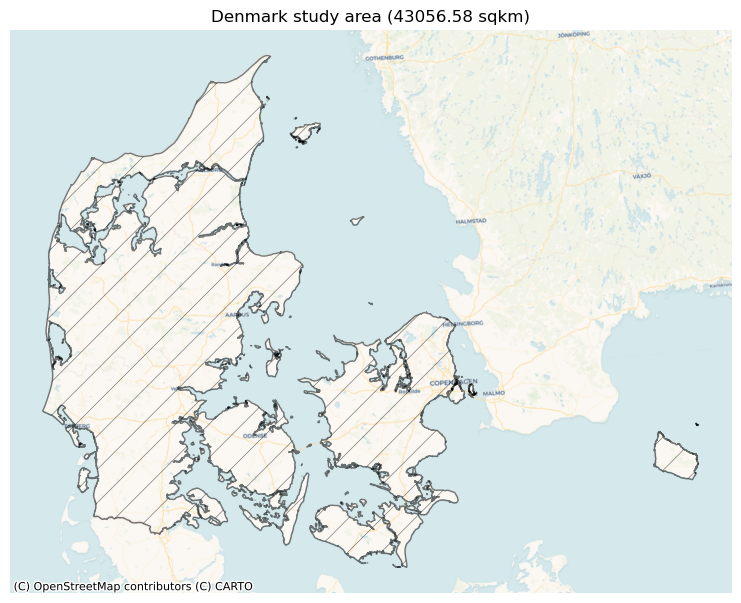

In [3]:
# Plot study area

set_renderer(renderer_map)
print("This study area will be used for the analysis:")

fig, ax = plt.subplots(1, figsize=pdict["fsmap"])
study_area_poly.plot(ax=ax, edgecolor=pdict["base"], facecolor='none',alpha=pdict["alpha_back"],hatch='/')
ax.set_axis_off()
cx.add_basemap(ax, crs=study_area_poly.crs, source=cx_tile_1)
ax.set_title(f"{area_name} study area ({area / 1000000:.2f} sqkm)")

plot_func.save_fig(fig, osm_results_static_maps_fp + "area_size_osm")

### Create analysis grid

<div class="alert alert-block alert-info">
<b>User configurations</b>
<p>
The grid is used to compute <b>local</b> results for many of the quality metrics, i.e. on grid cell level. The cell size of the grid cells must be specified in the configuration file. Smaller grid cells will increase the computation time but give a more granular result. The grid cell size should not be smaller than the scale at which you would expect actual differences in data quality.
</p>
</div>

Creating hexagons at resolution 8...
The grid contains 78175 hex cells with an average area of 0.59 km2.
This grid will be used for local (grid cell level) analysis:


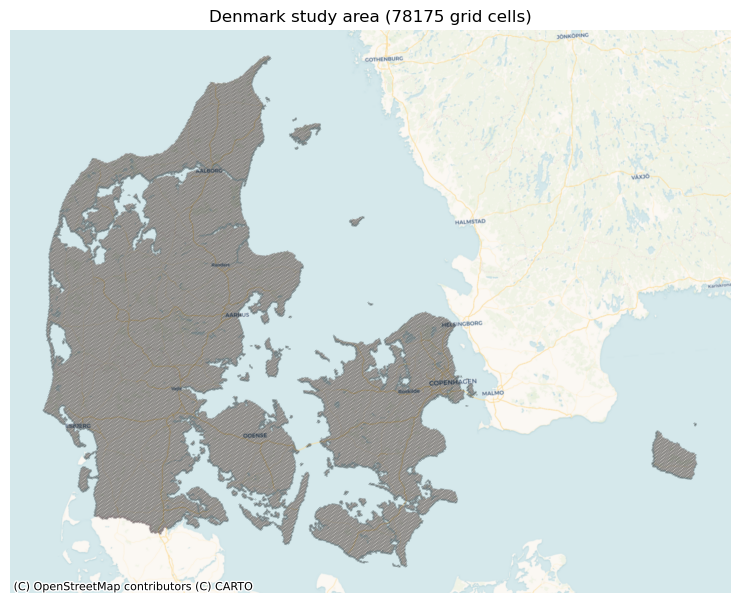

In [4]:
# Create and plot grid

set_renderer(renderer_map)

grid = eval_func.create_h3_grid(study_area_poly, 8, study_crs, 500)

fig, ax = plt.subplots(1, figsize=pdict["fsmap"])
grid_cell_area = grid.area.mean() / 1000000 # in km2
print(f"The grid contains {len(grid)} hex cells with an average area of {grid_cell_area:.2f} km2.")
print("This grid will be used for local (grid cell level) analysis:")
grid.plot(ax=ax, facecolor="none", edgecolor=pdict["base"], alpha=pdict["alpha_back"],linewidth=0.2)
ax.set_axis_off()
cx.add_basemap(ax, crs=study_area_poly.crs, source=cx_tile_1)
ax.set_title(
    f"{area_name} study area ({len(grid)} grid cells)"
)

plot_func.save_fig(fig, osm_results_static_maps_fp + "area_grid_osm")

## Download and preprocess OSM data

This step:

- Downloads data from OpenStreetMap using OSMnx.
- Projects the data to the chosen CRS.
- Creates a subnetwork consisting only of bicycle infrastructure.
- Classifies all edges in the bicycle network based on whether they are protected or unprotected bicycle infrastructure, how they have been digitized, and whether they allow for bidirectional travel or not.
- Simplifies the network.
- Creates copies of all edge and node data sets indexed by their intersecting grid cell.

**OSM data model**

In OSM, street network data are stored using *nodes* (points) and *ways* (lines). In BikeDNA, OSM data are converted to a network structure consisting of *nodes* and *edges* (we use the terminology used in OSMnx). Edges represents the actual infrastructure, such as bike lanes and paths, while nodes represents the start and end points for the edges, as well as all intersections. For further details, read more about the [OSM data model](https://alga.win.tue.nl/tutorials/openstreetmap/) and the [network data model](https://networkx.org/documentation/stable/reference/introduction.html).

<details><summary><b>Network simplification</b></summary>

When converting a set of linestrings to network (graph) format, not all vertices (nodes) are of equal meaning. For the geometry of edges, all nodes are used to define the shape of the edge. For the topology of the network, however, only those nodes that are endpoints or intersection points with other edges are needed, while all other (so-called 'interstitial') nodes do not add any information. To compare the structure and true ratio between nodes and edges in a network, a simplified network representation which only includes nodes at endpoints and intersections, or where the value of important attributes changes, is required. An additional advantage of simplifying the network is the resulting substantial reduction of the number of nodes and edges, which makes computational routines much faster.

Note that the simplification function only simplifies and merges edges that have identical values for important attributes such as geometry type, bicycle direction, and protection level. 

<p align="center">
<img src='../../images/network_simplification_illustration.png' width=300/>

*Non-simplified network (left) and simplified network (right)*.

</p>

As part of the simplification routine, in cases where there are several edges between the same pair of nodes ('parallel edges' or 'multiedges'), only one of the edges is retained.

To read more about the modified OSMnx simplification [(Boeing, 2017)](https://geoffboeing.com/publications/osmnx-complex-street-networks/) used here, we refer to this [GitHub repository](https://github.com/anerv/NERDS_osmnx) which contains both the simplification functions, explanation of the logic and a demonstration.

</details>

<div class="alert alert-block alert-danger">
<b>Warning</b>
<p>
Depending on the size of your study area, getting data through OSMnx can take a little while (for a city around the size of Copenhagen it can take two minutes).
</p>
</div>

<div class="alert alert-block alert-info">
<b>User configurations</b>
<p>
In the following step, the dedicated bicycle infrastructure is extracted from the general street network. Depending on the type of bicycle infrastructure and OSM tagging tradition in your area, the queries used for retrieving the bicycle network might need to be adapted (this is done in the configuration file under <i>bicycle_infrastructure_queries</i>).
</p>
</div>

In [6]:
# Creating OSM object
osm = pyrosm.OSM("../../data/OSM/dk/raw/denmark-latest.osm.pbf")

extra_attr = [
    "surface",
    "cycleway:left",
    "cycleway:right",
    "cycleway:both",
    "cycleway:width",
    "cycleway:oneway",
    "oneway:bicycle",
    "maxspeed",
    "cycleway:surface",
]

In [7]:
start = timer()

print("Creating edge and node datasets...")
nodes, edges = osm.get_network(
    nodes=True, network_type="cycling", extra_attributes=extra_attr
)
end = timer()
print((end - start) / 60)

Creating edge and node datasets...
26.36926774913336


In [8]:
# Drop unnecessary cols
drop_cols = [
    "overtaking",
    "psv",
    "ref",
    "int_ref",
    "construction",
    "proposed",
    "timestamp",
    "version",
    "osm_type",
    "passing_places",
    "area",
    "footway",
    "foot",
    "junction",
    "path",
    "sidewalk",
    "tracktype",
    "turn",
    "tags",
    "lanes",
    "busway",
    "motorroad",
    "motor_vehicle",
    "motorcar",
    "name",
    "service",
    "changeset"
]

drop_cols = [c for c in drop_cols if c in edges.columns]
edges.drop(
    drop_cols,
    axis=1,
    inplace=True,
)

nodes_drop_cols = [c for c in drop_cols if c in nodes.columns]

nodes.drop(
    nodes_drop_cols,
    axis=1,
    inplace=True,
)

**Get bicycle edges & nodes**

In [9]:
# Clean col names
edges = graph_func.clean_col_names(edges)

# Get bicycle edges
edges["bicycle_infrastructure"] = "no"

for q in bicycle_infrastructure_queries.values():

    try:
        osm_filtered = edges.query(q)

    except Exception:
        print("Exception occured when quering with:", q)
        print("Please check if the columns used in the query are present in the data")

    edges.loc[osm_filtered.index, "bicycle_infrastructure"] = "yes"

bicycle_edges = edges.loc[edges.bicycle_infrastructure == "yes"].copy()

# Get bicycle nodes
bicycle_nodes_id = set(bicycle_edges.u.to_list() + bicycle_edges.v.to_list())

bicycle_nodes = nodes.loc[nodes.id.isin(bicycle_nodes_id)]

**Augment**

In [10]:
# Define whether bicycle infrastructure is in both or one direction and whether it is one- or bidirectional

bicycle_edges = eval_func.simplify_bicycle_tags(bicycle_edges, simplify_tags_queries)

for key, value in bicycle_edges.bicycle_bidirectional.value_counts().items():
    perc = np.round(100*value/len(bicycle_edges),2)
    print(f"Edges where 'bicycle_bidirectional' is {key}: {value} out of {len(bicycle_edges)} ({perc}%)")
print("\n")

for key, value in bicycle_edges.bicycle_geometries.value_counts().items():
    perc = np.round(100*value/len(bicycle_edges),2)
    print(f"Edges where the geometry type is '{key}': {value} out of {len(bicycle_edges)} ({perc}%)")
print("\n")

# Classify edges as protected or unprotected
bicycle_edges = eval_func.define_protected_unprotected(
    bicycle_edges, osm_bicycle_infrastructure_type
)

for key, value in bicycle_edges.protected.value_counts().items():
    perc = np.round(100*value/len(bicycle_edges),2)
    print(f"Edges where the protection level is '{key}': {value} out of {len(bicycle_edges)} ({perc}%)")
print("\n")


Edges where 'bicycle_bidirectional' is False: 341040 out of 482330 (70.71%)
Edges where 'bicycle_bidirectional' is True: 141290 out of 482330 (29.29%)


Edges where the geometry type is 'true_geometries': 338359 out of 482330 (70.15%)
Edges where the geometry type is 'centerline': 143971 out of 482330 (29.85%)


Edges where the protection level is 'protected': 428018 out of 482330 (88.74%)
Edges where the protection level is 'unprotected': 52539 out of 482330 (10.89%)
Edges where the protection level is 'mixed': 1773 out of 482330 (0.37%)




In [11]:
bicycle_nodes.to_parquet('../../data/OSM/dk/processed/bicycle_nodes.parquet')
bicycle_edges.to_parquet('../../data/OSM/dk/processed/bicycle_edges.parquet')

**Create networkX graph with OSMnx structure**

In [12]:
bicycle_nodes = gpd.read_parquet('../../data/OSM/dk/processed/bicycle_nodes.parquet')
bicycle_edges = gpd.read_parquet('../../data/OSM/dk/processed/bicycle_edges.parquet')

In [14]:
# Create networkx graph

G = osm.to_graph(bicycle_nodes, bicycle_edges, network_type="cycling", graph_type="networkx", retain_all=True)

# Convert to OSMnx structure

ox_nodes, ox_edges = ox.graph_to_gdfs(G)

G_ox = ox.graph_from_gdfs(ox_nodes, ox_edges)

In [15]:
ox_nodes.to_parquet('../../data/OSM/dk/processed/ox_nodes.parquet')
ox_edges.to_parquet('../../data/OSM/dk/processed/ox_edges.parquet')

**Get simplified and undirected network**

In [16]:
# requires edges without geometries
for n1, n2, d in G_ox.edges(data=True):
    d.pop('geometry', None)

# Simplify bicycle network
bicycle_graph_simplified = simp_func.simplify_graph(
    G_ox,
    attributes=[
        "bicycle_infrastructure",
        "bicycle_bidirectional",
        "bicycle_geometries",
        "protected",
    ],
    remove_rings=False,
)

print("Simplification successfull!")

# Get undirected network representation
bicycle_graph_simplified = ox.get_undirected(bicycle_graph_simplified)
bicycle_graph = ox.get_undirected(G_ox)

print("Successfully created undirected networks!")

# Project graphs
bicycle_graph_simplified = ox.project_graph(bicycle_graph_simplified,to_crs=study_crs)
bicycle_graph = ox.project_graph(bicycle_graph,to_crs=study_crs)

assert bicycle_graph.graph["crs"] == study_crs
assert bicycle_graph_simplified.graph["crs"] == study_crs

print("Graps have been reprojected!")

# Get undirected edge and node dataframes
bicycle_nodes_simplified, bicycle_edges_simplified = ox.graph_to_gdfs(
    bicycle_graph_simplified, nodes=True
)

bicycle_nodes, bicycle_edges = ox.graph_to_gdfs(
    bicycle_graph, nodes=True
)

assert bicycle_edges.crs == study_crs
assert bicycle_nodes.crs == study_crs
assert bicycle_edges_simplified.crs == study_crs
assert bicycle_nodes_simplified.crs == study_crs

# Remove attributes from graphs (no longer needed after simplification)
keep_cols = ['geometry','osmid']
drop_cols = [c for c in ox_edges.columns if c not in keep_cols]


for n1, n2, d in bicycle_graph.edges(data=True):
    for att in drop_cols:
        d.pop(att, None)

for n1, n2, d in bicycle_graph_simplified.edges(data=True):
    for att in drop_cols:
        d.pop(att, None)

Simplification successfull!
Successfully created undirected networks!
Graps have been reprojected!


**Compute infrastructure length, create unique ids etc.**

In [17]:
# Measure the length of bicycle infrastructure (!=from length of edges)
bicycle_edges_simplified["length"] = bicycle_edges_simplified.geometry.length
bicycle_edges_simplified["infrastructure_length"] = bicycle_edges_simplified.apply(
    lambda x: eval_func.measure_infrastructure_length(
        edge=x.geometry,
        geometry_type=x.bicycle_geometries,
        bidirectional=x.bicycle_bidirectional,
        bicycle_infrastructure=x.bicycle_infrastructure,
    ),
    axis=1,
)

# Add "multiple edge" attribute to each edge of the graph
for e in bicycle_graph.edges:
    bicycle_graph.edges[e]["multiedge"] = 0

# Count multiple edges and store info at key 0
# (simplification routine keeps only key 0)
for u, v, k in bicycle_graph.edges:
    if k > 0:
        bicycle_graph.edges[u, v, 0]["multiedge"] += 1

# Creating columns with unique feature id (required by some functions)
bicycle_edges["edge_id"] = bicycle_edges.reset_index().index
bicycle_edges_simplified["edge_id"] = bicycle_edges_simplified.reset_index().index

osm_id_dict = bicycle_edges["edge_id"].to_dict()
nx.set_edge_attributes(bicycle_graph, osm_id_dict, "edge_id")

osm_id_dict_s = bicycle_edges_simplified["edge_id"].to_dict()
nx.set_edge_attributes(bicycle_graph_simplified, osm_id_dict_s, "edge_id")

# Saving data to graphs
osm_l_dict = bicycle_edges["length"].to_dict()
nx.set_edge_attributes(bicycle_graph, osm_l_dict, "length")

osm_l_dict_s = bicycle_edges_simplified["length"].to_dict()
nx.set_edge_attributes(bicycle_graph_simplified, osm_l_dict_s, "length")

osm_il_dict = bicycle_edges_simplified["infrastructure_length"].to_dict()
nx.set_edge_attributes(bicycle_graph_simplified, osm_il_dict, "infrastructure_length")

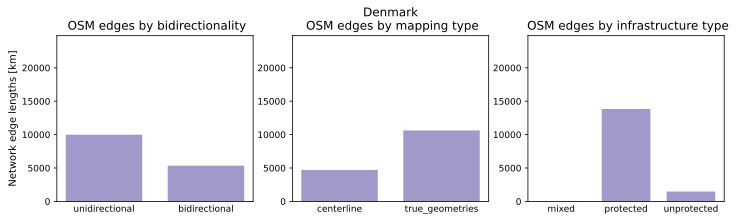

In [18]:
# Plot global statistics (by network length)

set_renderer(renderer_plot)
ymax = bicycle_edges_simplified.infrastructure_length.sum() * 1.2 /1000 # conversion m to km
subplotdata = []
subplotbar_labels = []
subplottitle = []
subplotx_positions = []

# attribute: bidirectional
x = []
y = []

for value in np.unique(bicycle_edges.bicycle_bidirectional):
    x.append(str(value))
    y.append(bicycle_edges[bicycle_edges["bicycle_bidirectional"]==value].length.sum()/1000) # conversion m to km

plot_func.make_bar_plot(
    data = y,
    bar_labels = ["unidirectional", "bidirectional"],
    y_label = "Network edge length [km]",
    x_positions = [i for i in range(len(x))],
    title = f"{area_name}\n OSM edges by bidirectionality",
    bar_colors = len(x)*[pdict["osm_base"]],
    filepath = osm_results_plots_fp + "edge_global_bidirectional",
    ylim = ymax,
    figsize=pdict["fsbar_small"]
); plt.close()
subplotdata.append(tuple(y))
subplotbar_labels.append(["unidirectional", "bidirectional"])
subplottitle.append(f"\n OSM edges by bidirectionality")
subplotx_positions.append([i for i in range(len(x))])

# attribute: bicycle geometry (mapping type)
x = []
y = []

for value in np.unique(bicycle_edges.bicycle_geometries):
    x.append(value)
    y.append(bicycle_edges[bicycle_edges["bicycle_geometries"]==value].length.sum()/1000) # conversion m to km

plot_func.make_bar_plot(
    data = y,
    bar_labels = x,
    y_label = "Network edge lengths [km]",
    x_positions = [i for i in range(len(x))],
    title = f"{area_name}\n OSM edges by mapping type",
    bar_colors = len(x)*[pdict["osm_base"]],
    filepath = osm_results_plots_fp + "edge_global_mappingtype",
    ylim = ymax,
    figsize=pdict["fsbar_small"]
); plt.close()
subplotdata.append(tuple(y))
subplotbar_labels.append(x)
subplottitle.append(f"{area_name}\n OSM edges by mapping type")
subplotx_positions.append([i for i in range(len(x))])

# attribute: protection
x = []
y = []

for value in np.unique(bicycle_edges.protected):
    x.append(value)
    y.append(bicycle_edges[bicycle_edges["protected"]==value].length.sum()/1000) # conversion m to km

plot_func.make_bar_plot(
    data = y,
    bar_labels = x,
    y_label = "Network edge lengths [km]",
    x_positions = [i for i in range(len(x))],
    title = f"{area_name}\n OSM edges by infrastructure type",
    bar_colors = len(x)*[pdict["osm_base"]],
    filepath = osm_results_plots_fp + "edge_global_infrastructuretype",
    ylim = ymax,
    figsize=pdict["fsbar_small"]
); plt.close()
subplotdata.append(tuple(y))
subplotbar_labels.append(x)
subplottitle.append(f"\n OSM edges by infrastructure type")
subplotx_positions.append([i for i in range(len(x))])

# Next to each other
plot_func.make_bar_subplots(
    subplot_data=subplotdata,
    nrows=1,
    ncols=3,
    bar_labels=subplotbar_labels,
    y_label=["Network edge lengths [km]", "", ""],
    x_positions=subplotx_positions,
    title=subplottitle,
    bar_colors=len(x)*[pdict["osm_base"]],
    filepath=osm_results_plots_fp + "edge_global",
    ylim=ymax
);


In [19]:
# Overview of data from OSM
graph_area = eval_func.get_graph_area(bicycle_nodes_simplified, study_area_poly.unary_union, study_crs)
print(f"The network covers an area of {graph_area/ 1000000:.2f} km2.")
print(
    f"The length of the OSM network with bicycle infrastructure is {bicycle_edges_simplified.infrastructure_length.sum()/1000 :.2f} km."
)

The network covers an area of 42960.78 km2.
The length of the OSM network with bicycle infrastructure is 20680.63 km.


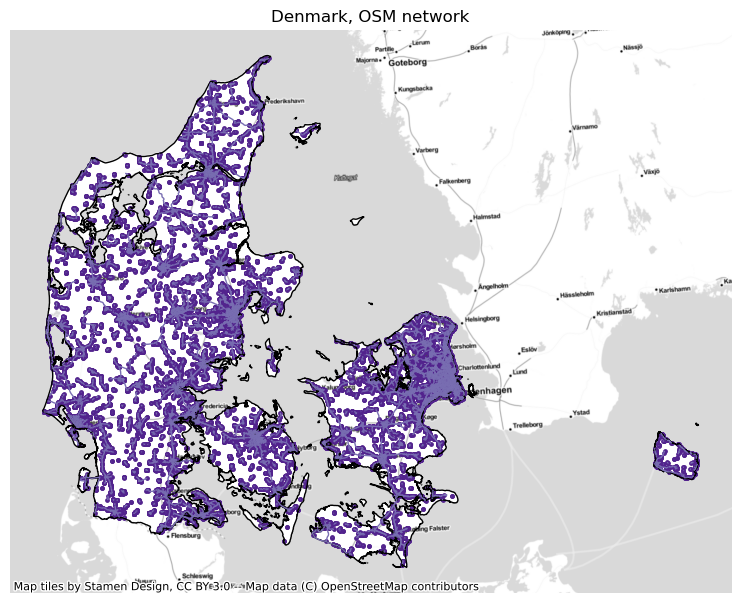

In [20]:
# Plot network

set_renderer(renderer_map)
fig, ax = plt.subplots(1, figsize=pdict["fsmap"])
bicycle_edges_simplified.plot(ax=ax, color=pdict["osm_base"], linewidth=pdict["line_base"])
bicycle_nodes_simplified.plot(ax=ax, color=pdict["osm_emp"], markersize=pdict["mark_emp"])
study_area_poly.plot(ax=ax, edgecolor=pdict["base"], facecolor="None", linewidth=1)
cx.add_basemap(ax=ax, crs=study_area_poly.crs, source=cx_tile_2)
ax.set_axis_off()
ax.set_title(f"{area_name}, OSM network")

plot_func.save_fig(fig, osm_results_static_maps_fp + "area_network_osm")


In [21]:
# Joining grid cell id to network elements
osm_edges_simp_joined = gpd.overlay(
    bicycle_edges_simplified.reset_index(), grid, how="intersection"
)
osm_edges_joined = gpd.overlay(bicycle_edges.reset_index(), grid, how="intersection")

osm_nodes_simp_joined = gpd.overlay(
    bicycle_nodes_simplified, grid, how="intersection"
)
osm_nodes_joined = gpd.overlay(bicycle_nodes, grid, how="intersection")

print("Network elements indexed by grid cell!")

# Count features in each grid cell
all_data_osm = [
    osm_edges_joined,
    osm_nodes_joined,
    osm_edges_simp_joined,
    osm_nodes_simp_joined,
]
labels_osm = ["osm_edges", "osm_nodes", "osm_simplified_edges", "osm_simplified_nodes"]

for data, label in zip(all_data_osm, labels_osm):

    df = eval_func.count_features_in_grid(data, label)

    grid = eval_func.merge_results(grid, df, "left")
    
# Recomputing infrastructure length for data joined to grid
osm_edges_simp_joined["length"] = osm_edges_simp_joined["geometry"].length
osm_edges_simp_joined["infrastructure_length"] = osm_edges_simp_joined.apply(
    lambda x: eval_func.measure_infrastructure_length(
        edge=x.geometry,
        geometry_type=x.bicycle_geometries,
        bidirectional=x.bicycle_bidirectional,
        bicycle_infrastructure=x.bicycle_infrastructure,
    ),
    axis=1,
)

assert round(bicycle_edges_simplified.infrastructure_length.sum() / 10000, 0) == round(
    osm_edges_simp_joined.infrastructure_length.sum() / 10000, 0
)

Network elements indexed by grid cell!


In [22]:
# Save OSM data
exec(open("../settings/save_osmdata.py").read())

OSM nodes and edges saved successfully!
OSM networks saved successfully!
OSM grid saved successfully!


***

In [23]:
from time import strftime
print("Time of analysis: " + strftime("%a, %d %b %Y %H:%M:%S"))

Time of analysis: Mon, 22 May 2023 15:56:43
